 # Playground Spiral Experiments

In [1]:
# Install packages if missing
# !pip install -q torch matplotlib
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
# Seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
# Spiral Dataset Generator
def make_spiral(n=500, noise=0.2, seed=0):
    rng = np.random.default_rng(seed)
    n2 = n // 2
    t = np.linspace(0, 2*np.pi, n2)
    r = np.linspace(0.2, 1.0, n2)
    x1 = np.c_[r*np.cos(t), r*np.sin(t)] + noise * rng.standard_normal((n2, 2))
    x2 = np.c_[-r*np.cos(t), -r*np.sin(t)] + noise * rng.standard_normal((n2, 2))
    Xs = np.vstack([x1, x2]).astype('float32')
    ys = np.r_[np.zeros(n2), np.ones(n2)].astype('float32')
    return Xs, ys

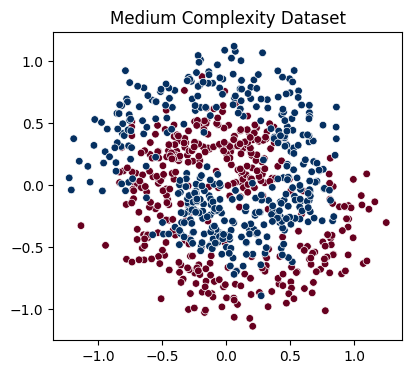

In [4]:
# Medium Complexity Dataset
X_medium, y_medium = make_spiral(n=800, noise=0.15, seed=0)

plt.figure(figsize=(4.5,4))
plt.scatter(X_medium[:,0], X_medium[:,1], c=y_medium, cmap='RdBu', s=30, edgecolor='white', linewidth=0.5)
plt.title('Medium Complexity Dataset')
plt.show()

In [5]:
# Data Preparation
def prepare_data(X, y, test_ratio=0.2):
    idx = np.arange(len(X))
    np.random.shuffle(idx)
    split = int(len(X)*(1-test_ratio))
    train_idx, val_idx = idx[:split], idx[split:]
    X_train_t = torch.from_numpy(X[train_idx])
    y_train_t = torch.from_numpy(y[train_idx]).unsqueeze(1)
    X_val_t = torch.from_numpy(X[val_idx])
    y_val_t = torch.from_numpy(y[val_idx]).unsqueeze(1)
    return X_train_t, y_train_t, X_val_t, y_val_t

X_train_t, y_train_t, X_val_t, y_val_t = prepare_data(X_medium, y_medium)


In [6]:
# Model Builder
def build_model(hidden_layers):
    layers = []
    input_dim = 2
    for h in hidden_layers:
        layers.append(nn.Linear(input_dim, h))
        layers.append(nn.ReLU())
        input_dim = h
    layers.append(nn.Linear(input_dim, 1))
    layers.append(nn.Sigmoid())
    return nn.Sequential(*layers)

In [7]:
def train_model(model, X_train_t, y_train_t, X_val_t, y_val_t, epochs=1500, lr=1e-3):
    loss_fn = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_losses, val_losses = [], []
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        loss = loss_fn(model(X_train_t), y_train_t)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            val_loss = loss_fn(model(X_val_t), y_val_t)
            val_losses.append(val_loss.item())

    model.eval()
    with torch.no_grad():
        val_probs = model(X_val_t)
        val_pred_labels = (val_probs > 0.5).float()
        val_acc = (val_pred_labels.eq(y_val_t)).float().mean().item()

    return train_losses, val_losses, val_acc

In [8]:
# Different Architectures to Experiment With
architectures = {
    "Micro 1 layer [4]": [4],
    "Micro 2 layers [4, 4]": [4, 4],
    "1 hidden layer [32]": [32], 
    "2 hidden layers [16,16]": [16,16],
    "2 hidden layers [32, 32]": [32, 32], 
    "2 hidden layers [32, 16]": [32, 16], 
    "3 hidden layers [16,16,16]": [16,16,16],
    "3 hidden layers [16,12,8]": [16,12,8],
    "3 hidden layers [32,24,16]": [32,24,16],
    "4 hidden layers [32,24,16,8]": [32,24,16,8],
}


In [9]:
# Train & Evaluate Architectures
results_hidden = {}
for name, layers in architectures.items():
    print(f"Training {name}...")
    model = build_model(layers)
    train_losses, val_losses, val_acc = train_model(model, X_train_t, y_train_t, X_val_t, y_val_t)
    results_hidden[name] = {
        "model": model,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "val_acc": val_acc
    }
    print(f"{name} → Validation Accuracy: {val_acc:.3f}")

Training Micro 1 layer [4]...
Micro 1 layer [4] → Validation Accuracy: 0.531
Training Micro 2 layers [4, 4]...
Micro 2 layers [4, 4] → Validation Accuracy: 0.625
Training 1 hidden layer [32]...
1 hidden layer [32] → Validation Accuracy: 0.850
Training 2 hidden layers [16,16]...
2 hidden layers [16,16] → Validation Accuracy: 0.881
Training 2 hidden layers [32, 32]...
2 hidden layers [32, 32] → Validation Accuracy: 0.894
Training 2 hidden layers [32, 16]...
2 hidden layers [32, 16] → Validation Accuracy: 0.881
Training 3 hidden layers [16,16,16]...
3 hidden layers [16,16,16] → Validation Accuracy: 0.869
Training 3 hidden layers [16,12,8]...
3 hidden layers [16,12,8] → Validation Accuracy: 0.894
Training 3 hidden layers [32,24,16]...
3 hidden layers [32,24,16] → Validation Accuracy: 0.863
Training 4 hidden layers [32,24,16,8]...
4 hidden layers [32,24,16,8] → Validation Accuracy: 0.869


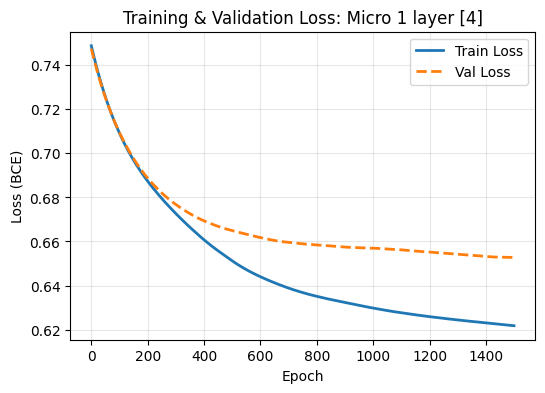

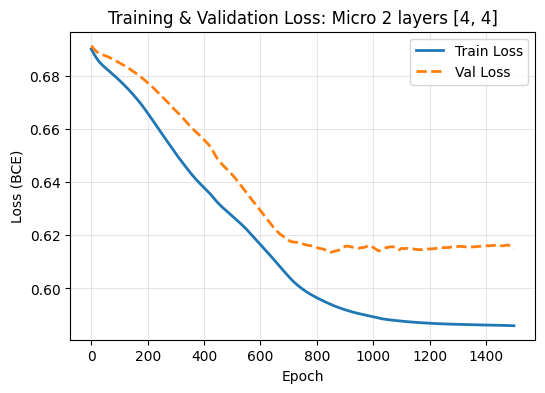

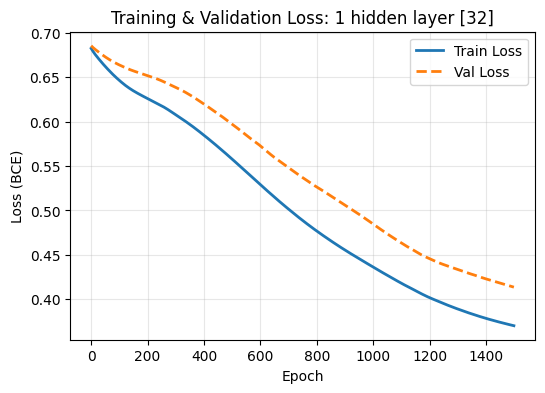

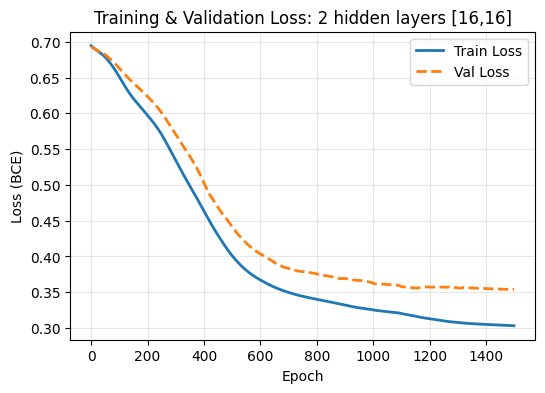

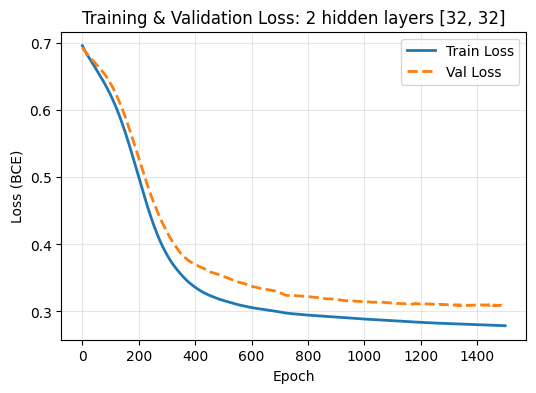

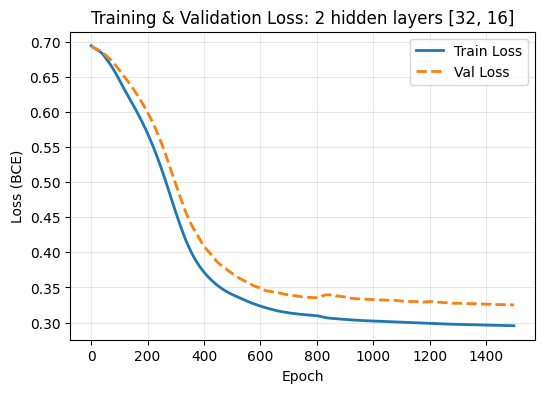

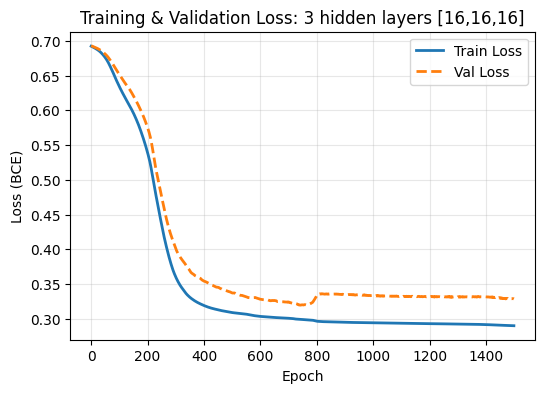

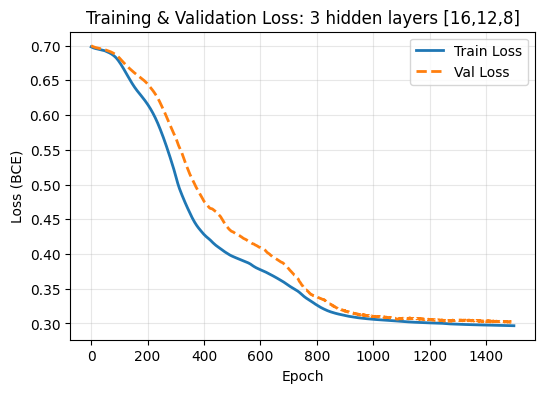

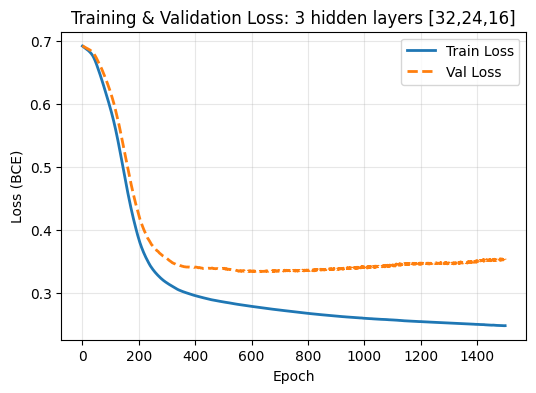

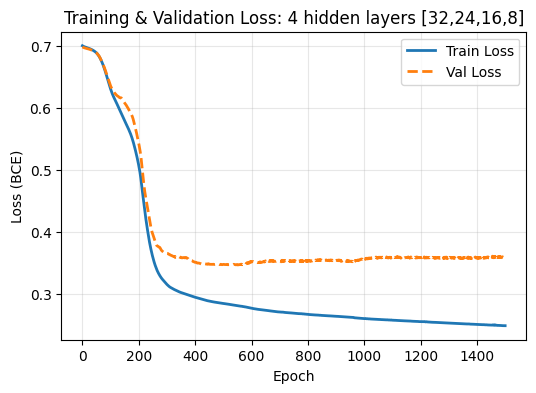

In [10]:
# Plot Losses
for name, res in results_hidden.items():
    plt.figure(figsize=(6,4))
    plt.plot(res["train_losses"], label="Train Loss", linewidth=2)
    plt.plot(res["val_losses"], label="Val Loss", linestyle='--', linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Loss (BCE)")
    plt.title(f"Training & Validation Loss: {name}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

Micro 1 layer [4]


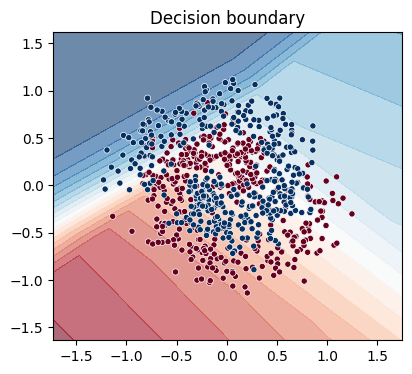

Micro 2 layers [4, 4]


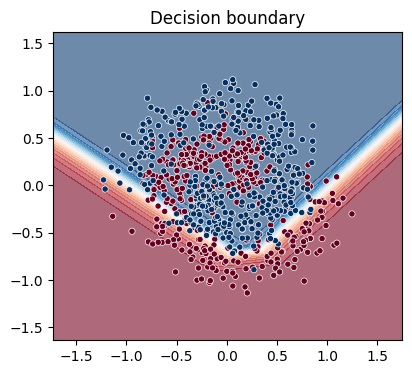

1 hidden layer [32]


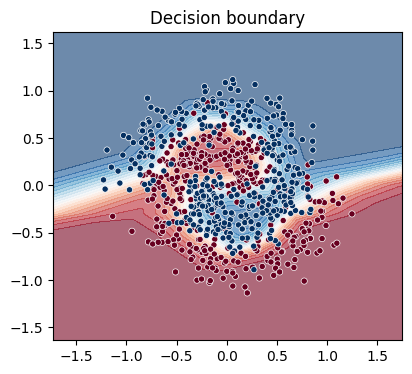

2 hidden layers [16,16]


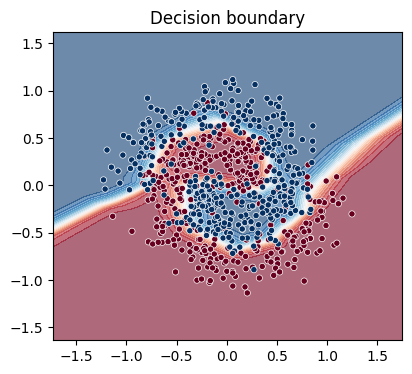

2 hidden layers [32, 32]


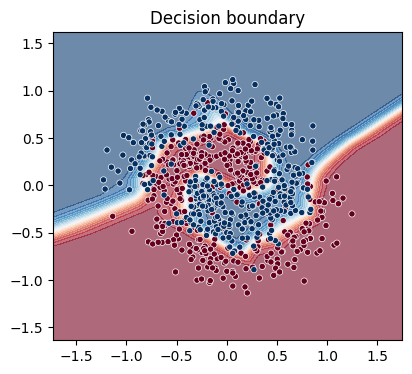

2 hidden layers [32, 16]


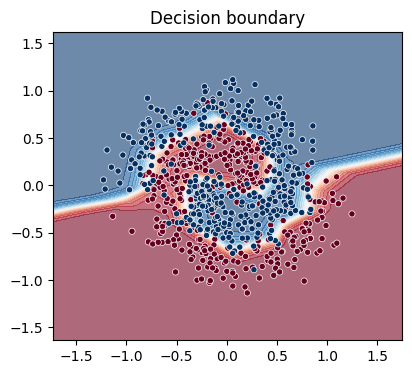

3 hidden layers [16,16,16]


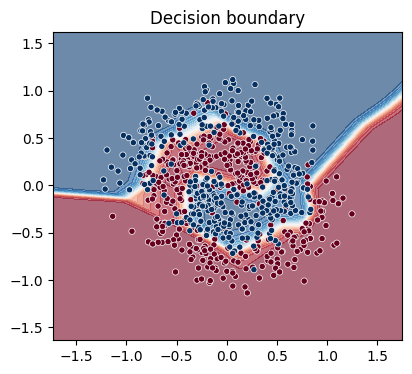

3 hidden layers [16,12,8]


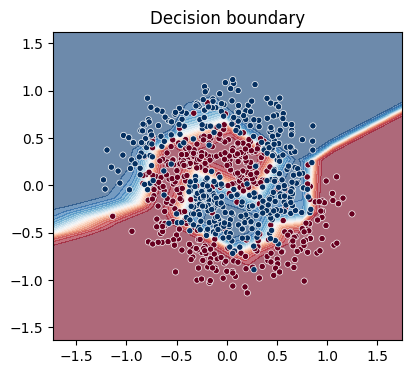

3 hidden layers [32,24,16]


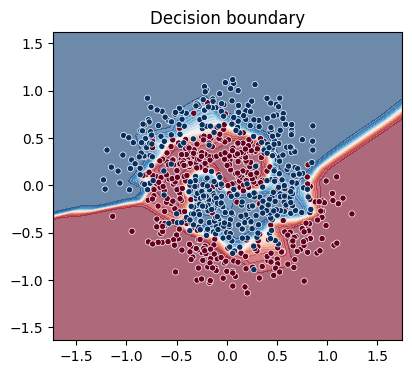

4 hidden layers [32,24,16,8]


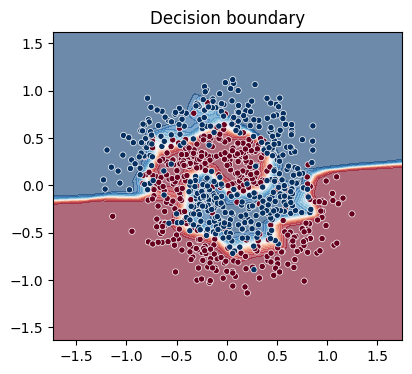

In [11]:
# Plot Decision Boundary
def plot_decision_boundary(model, X, y):
    xx, yy = np.meshgrid(
        np.linspace(X[:,0].min()-0.5, X[:,0].max()+0.5, 200),
        np.linspace(X[:,1].min()-0.5, X[:,1].max()+0.5, 200)
    )
    grid = np.c_[xx.ravel(), yy.ravel()].astype('float32')
    grid_t = torch.from_numpy(grid)
    model.eval()
    with torch.no_grad():
        probs = model(grid_t).numpy().reshape(xx.shape)
    plt.figure(figsize=(4.5,4))
    plt.contourf(xx, yy, probs, levels=20, cmap='RdBu', alpha=0.6)
    plt.scatter(X[:,0], X[:,1], c=y, cmap='RdBu', edgecolor='white', linewidth=0.5, s=20)
    plt.title('Decision boundary')
    plt.show()

for name, res in results_hidden.items():
    print(name)
    plot_decision_boundary(res["model"], X_medium, y_medium)


Worst Hidden Layer Model: Micro 1 layer [4] → Accuracy: 0.531


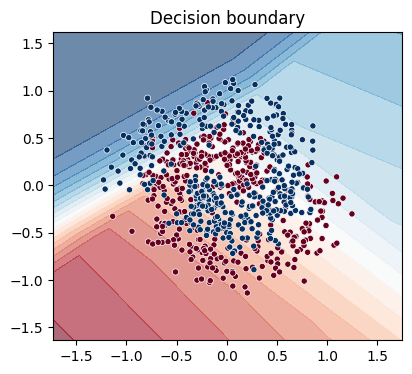

In [12]:
# Find Worst Architecture
worst_arch = min(results_hidden.items(), key=lambda x: x[1]["val_acc"])
print("Worst Hidden Layer Model:", worst_arch[0], "→ Accuracy:", round(worst_arch[1]["val_acc"],3))
plot_decision_boundary(worst_arch[1]["model"], X_medium, y_medium)

Best Maximal Model: 2 hidden layers [32, 32] → Accuracy: 0.894


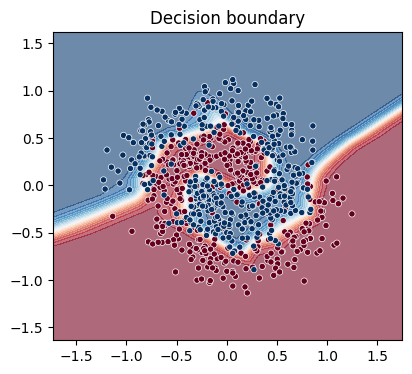

In [13]:
# Find Best Architecture
best_arch = max(results_hidden.items(), key=lambda x: x[1]["val_acc"])
print("Best Maximal Model:", best_arch[0], "→ Accuracy:", round(best_arch[1]["val_acc"],3))
plot_decision_boundary(best_arch[1]["model"], X_medium, y_medium)